<a href="https://colab.research.google.com/github/anujkum25/diffusion/blob/main/MPDD_finetune_stable_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-cv==0.6.0 -q
!pip install -U tensorflow==2.15.0 -q
!pip install keras-core==0.1.7 -q
!pip install keras==2.15.0 -q
!pip install tensorflow_datasets==4.9.6 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.3/756.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.73 requires ml_dt

In [ ]:
from textwrap import wrap
import os

import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.models.stable_diffusion.image_encoder import ImageEncoder
from keras_cv.models.stable_diffusion.noise_scheduler import NoiseScheduler
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder
from tensorflow import keras

Using TensorFlow backend


In [ ]:
data_path ="/content/drive/MyDrive/MPDD/"

data_frame = pd.read_csv(os.path.join(data_path, "caption2.csv"))

data_frame["path"] = data_frame["path"].apply(
    lambda x: os.path.join(data_path, x)
)

print(data_frame.shape)

data_frame.head()

(458, 2)


,path,caption
0,/content/drive/MyDrive/MPDD/MPDD_classificatio...,A good black bracket
1,/content/drive/MyDrive/MPDD/MPDD_classificatio...,A good black bracket
2,/content/drive/MyDrive/MPDD/MPDD_classificatio...,A good black bracket
3,/content/drive/MyDrive/MPDD/MPDD_classificatio...,A good black bracket
4,/content/drive/MyDrive/MPDD/MPDD_classificatio...,A good black bracket


In [ ]:
# The padding token and maximum prompt length are specific to the text encoder.
# If you're using a different text encoder be sure to change them accordingly.
PADDING_TOKEN = 49407
MAX_PROMPT_LENGTH = 77

# Load the tokenizer.
tokenizer = SimpleTokenizer()

#  Method to tokenize and pad the tokens.
def process_text(caption):
    tokens = tokenizer.encode(caption)
    tokens = tokens + [PADDING_TOKEN] * (MAX_PROMPT_LENGTH - len(tokens))
    return np.array(tokens)


# Collate the tokenized captions into an array.
tokenized_texts = np.empty((len(data_frame), MAX_PROMPT_LENGTH))

all_captions = list(data_frame["caption"].values)
for i, caption in enumerate(all_captions):
    tokenized_texts[i] = process_text(caption)

## Prepare a `tf.data.Dataset`

In this section, we'll prepare a `tf.data.Dataset` object from the input image file paths
and their corresponding caption tokens. The section will include the following:

* Pre-computation of the text embeddings from the tokenized captions.
* Loading and augmentation of the input images.
* Shuffling and batching of the dataset.

In [ ]:
import cv2

cv2.imread("/content/drive/MyDrive/MPDD/MPDD_classification/bracket_black/good/000.png")

array([[[ 67, 207, 160],
        [ 67, 207, 160],
        [ 67, 208, 160],
        ...,
        [ 25, 169, 115],
        [ 24, 169, 114],
        [ 24, 168, 114]],

       [[ 65, 206, 159],
        [ 62, 204, 157],
        [ 64, 206, 158],
        ...,
        [ 24, 168, 114],
        [ 26, 171, 116],
        [ 27, 171, 118]],

       [[ 62, 204, 157],
        [ 62, 204, 157],
        [ 63, 206, 158],
        ...,
        [ 24, 169, 114],
        [ 26, 170, 115],
        [ 26, 170, 116]],

       ...,

       [[ 14, 153, 102],
        [ 15, 154, 103],
        [ 12, 151, 100],
        ...,
        [  0, 118,  77],
        [  0, 117,  77],
        [  0, 117,  77]],

       [[ 14, 153, 102],
        [ 14, 153, 102],
        [ 10, 149,  98],
        ...,
        [  0, 118,  78],
        [  0, 116,  76],
        [  0, 115,  75]],

       [[ 12, 151, 100],
        [ 13, 152, 101],
        [ 11, 150,  99],
        ...,
        [  0, 117,  77],
        [  0, 115,  75],
        [  0, 114,  74]]

In [ ]:
RESOLUTION = 64
AUTO = tf.data.AUTOTUNE
POS_IDS = tf.convert_to_tensor([list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32)

augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.CenterCrop(RESOLUTION, RESOLUTION),
        #tf.keras.layers.CenterCrop(RESOLUTION, RESOLUTION),
        keras_cv.layers.RandomFlip(),
        tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ]
)
text_encoder = TextEncoder(MAX_PROMPT_LENGTH)


def process_image(image_path, tokenized_text):
    #image= cv2.imread(image_path)
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, 3)
    image = tf.image.resize(image, (RESOLUTION, RESOLUTION))
    return image, tokenized_text


def apply_augmentation(image_batch, token_batch):
    return augmenter(image_batch), token_batch


def run_text_encoder(image_batch, token_batch):
    return (
        image_batch,
        token_batch,
        text_encoder([token_batch, POS_IDS], training=False),
    )


def prepare_dict(image_batch, token_batch, encoded_text_batch):
    return {
        "images": image_batch,
        "tokens": token_batch,
        "encoded_text": encoded_text_batch,
    }


def prepare_dataset(image_paths, tokenized_texts, batch_size=1):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, tokenized_texts))
    dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.map(process_image, num_parallel_calls=AUTO).batch(batch_size)
    dataset = dataset.map(apply_augmentation, num_parallel_calls=AUTO)
    dataset = dataset.map(run_text_encoder, num_parallel_calls=AUTO)
    dataset = dataset.map(prepare_dict, num_parallel_calls=AUTO)
    return dataset.prefetch(AUTO)


The baseline Stable Diffusion model was trained using images with 512x512 resolution. It's
unlikely for a model that's trained using higher-resolution images to transfer well to
lower-resolution images. However, the current model will lead to OOM if we keep the
resolution to 512x512 (without enabling mixed-precision). Therefore, in the interest of
interactive demonstrations, we kept the input resolution to 256x256.

In [ ]:
# Prepare the dataset.
training_dataset = prepare_dataset(
    np.array(data_frame["path"]), tokenized_texts, batch_size=4
)

# Take a sample batch and investigate.
sample_batch = next(iter(training_dataset))

for k in sample_batch:
    print(k, sample_batch[k].shape)



images (4, 64, 64, 3)
tokens (4, 77)
encoded_text (4, 77, 768)


We can also take a look at the training images and their corresponding captions.

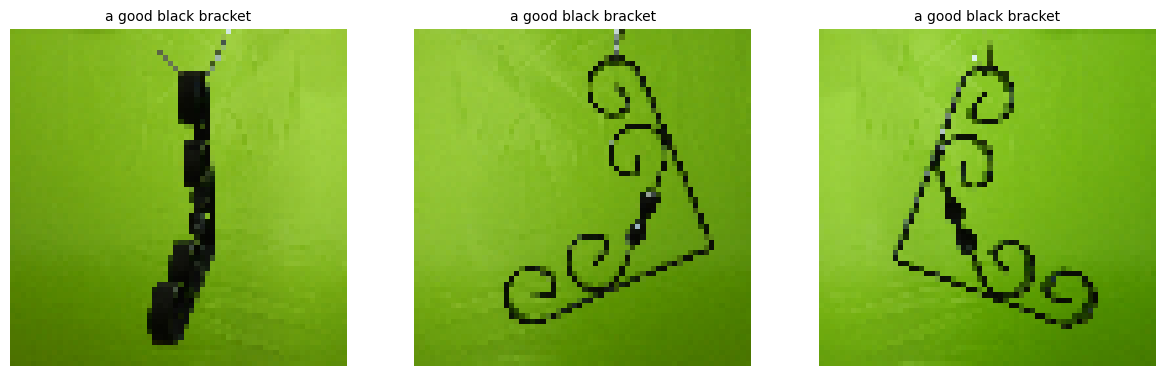

In [ ]:
plt.figure(figsize=(20, 10))

for i in range(3):
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow((sample_batch["images"][i] + 1) / 2)

    text = tokenizer.decode(sample_batch["tokens"][i].numpy().squeeze())
    text = text.replace("<|startoftext|>", "")
    text = text.replace("<|endoftext|>", "")
    text = "\n".join(wrap(text, 20))
    plt.title(text, fontsize=10)

    plt.axis("off")

## A trainer class for the fine-tuning loop

In [ ]:

class Trainer(tf.keras.Model):
    # Reference:
    # https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image.py

    def __init__(
        self,
        diffusion_model,
        vae,
        noise_scheduler,
        use_mixed_precision=False,
        max_grad_norm=1.0,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.diffusion_model = diffusion_model
        self.vae = vae
        self.noise_scheduler = noise_scheduler
        self.max_grad_norm = max_grad_norm

        self.use_mixed_precision = use_mixed_precision
        self.vae.trainable = False

    def train_step(self, inputs):

        images = inputs["images"]
        print("images shape:",images.shape)


        encoded_text = inputs["encoded_text"]
        print("encoded_text shape:",encoded_text.shape)

        batch_size = tf.shape(images)[0]

        with tf.GradientTape() as tape:
            # Project image into the latent space and sample from it.
            latents = self.sample_from_encoder_outputs(self.vae(images, training=True))
            print("latents shape:", latents.shape)


            # Know more about the magic number here:
            # https://keras.io/examples/generative/fine_tune_via_textual_inversion/
            latents = latents * 0.18215

            # Sample noise that we'll add to the latents.
            noise = tf.random.normal(tf.shape(latents))
            print("noise shape:", noise.shape)

            # Sample a random timestep for each image.
            timesteps = tnp.random.randint(
                0, self.noise_scheduler.train_timesteps, (batch_size,)
            )

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process).
            noisy_latents = self.noise_scheduler.add_noise(
                tf.cast(latents, noise.dtype), noise, timesteps
            )
            print("noisy_latents shape:", noisy_latents.shape)

            # Get the target for loss depending on the prediction type
            # just the sampled noise for now.
            target = noise  # noise_schedule.predict_epsilon == True

            # Predict the noise residual and compute loss.
            timestep_embedding = tf.map_fn(
                lambda t: self.get_timestep_embedding(t), timesteps, dtype=tf.float32
            )
            timestep_embedding = tf.squeeze(timestep_embedding, 1)
            model_pred = self.diffusion_model(
                [noisy_latents, timestep_embedding, encoded_text], training=True
            )
            loss = self.compiled_loss(target, model_pred)

            if self.use_mixed_precision:
                loss = self.optimizer.get_scaled_loss(loss)

        # Update parameters of the diffusion model.
        trainable_vars = self.diffusion_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        if self.use_mixed_precision:
            gradients = self.optimizer.get_unscaled_gradients(gradients)
        gradients = [tf.clip_by_norm(g, self.max_grad_norm) for g in gradients]
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {m.name: m.result() for m in self.metrics}

    def get_timestep_embedding(self, timestep, dim=320, max_period=10000):
        half = dim // 2
        log_max_period = tf.math.log(tf.cast(max_period, tf.float32))
        freqs = tf.math.exp(
            -log_max_period * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        embedding = tf.reshape(embedding, [1, -1])
        return embedding

    def sample_from_encoder_outputs(self, outputs):
        mean, logvar = tf.split(outputs, 2, axis=-1)
        logvar = tf.clip_by_value(logvar, -30.0, 20.0)
        std = tf.exp(0.5 * logvar)
        sample = tf.random.normal(tf.shape(mean), dtype=mean.dtype)
        return mean + std * sample

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        # Overriding this method will allow us to use the `ModelCheckpoint`
        # callback directly with this trainer class. In this case, it will
        # only checkpoint the `diffusion_model` since that's what we're training
        # during fine-tuning.
        self.diffusion_model.save_weights(
            filepath=filepath,
            overwrite=overwrite,
            #save_format=save_format,
            #options=options,
        )


One important implementation detail to note here: Instead of directly taking
the latent vector produced by the image encoder (which is a VAE), we sample from the
mean and log-variance predicted by it. This way, we can achieve better sample
quality and diversity.

It's common to add support for mixed-precision training along with exponential
moving averaging of model weights for fine-tuning these models. However, in the interest
of brevity, we discard those elements. More on this later in the tutorial.

## Initialize the trainer and compile it

In [ ]:
# Enable mixed-precision training if the underlying GPU has tensor cores.
USE_MP = True
if USE_MP:
    keras.mixed_precision.set_global_policy("mixed_float16")

image_encoder = ImageEncoder()
diffusion_ft_trainer = Trainer(
    diffusion_model=DiffusionModel(RESOLUTION, RESOLUTION, MAX_PROMPT_LENGTH),
    # Remove the top layer from the encoder, which cuts off the variance and only
    # returns the mean.

    vae=tf.keras.Model(
        image_encoder.input,
        image_encoder.layers[-2].output,
    ),


    noise_scheduler=NoiseScheduler(),
    use_mixed_precision=USE_MP,
)

# These hyperparameters come from this tutorial by Hugging Face:
# https://huggingface.co/docs/diffusers/training/text2image
lr = 1e-5
beta_1, beta_2 = 0.9, 0.999
weight_decay = (1e-2,)
epsilon = 1e-08

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=lr,
    weight_decay=weight_decay,
    beta_1=beta_1,
    beta_2=beta_2,
    epsilon=epsilon,
)
diffusion_ft_trainer.compile(optimizer=optimizer, loss="mse")

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


## Fine-tuning

To keep the runtime of this tutorial short, we just fine-tune for an epoch.

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
epochs = 10
ckpt_path = "finetuned_stable_diffusion.weights.h5"
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    save_weights_only=True,
    monitor="loss",
    mode="min",
)
history = diffusion_ft_trainer.fit(training_dataset, epochs=epochs, callbacks=[ckpt_callback])

Epoch 1/10
images shape: (None, 64, 64, 3)
encoded_text shape: (None, 77, 768)


Instructions for updating:
Use fn_output_signature instead


latents shape: (None, 8, 8, 4)
noise shape: (None, 8, 8, 4)
noisy_latents shape: (None, 8, 8, 4)
images shape: (None, 64, 64, 3)
encoded_text shape: (None, 77, 768)
latents shape: (None, 8, 8, 4)
noise shape: (None, 8, 8, 4)
noisy_latents shape: (None, 8, 8, 4)
  9/115 [=>............................] - ETA: 1:50:43 - loss: 0.1847

In [ ]:
import keras
from matplotlib import pyplot as plt

#plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()


In [ ]:

img_height = img_width = 64

model = keras_cv.models.StableDiffusion(
    img_width=img_width, img_height=img_height
)

model.diffusion_model.load_weights("finetuned_stable_diffusion.weights.h5")

In [ ]:
prompts = ["A black bracket", "A white bracket with rust", "A meta tube with dent"]

images_to_generate = 3
outputs = {}

for prompt in prompts:
    generated_images = model.text_to_image(
        prompt, batch_size=images_to_generate, unconditional_guidance_scale=40
    )
    outputs.update({prompt: generated_images})

In [ ]:

def plot_images(images, title):
    plt.figure(figsize=(50, 50))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.title(title, fontsize=12)
        plt.axis("off")


for prompt in outputs:
    plot_images(outputs[prompt], prompt)

In [ ]:
plt.imshow(outputs[prompt][2])
plt.savefig('/content/drive/MyDrive/DR_generated_images/image_grade_3_2.png')

In [ ]:
### epoch 1.

def plot_images(images, title):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.title(title, fontsize=12)
        plt.axis("off")


for prompt in outputs:
    plot_images(outputs[prompt], prompt)

In [ ]:
# example of calculating the frechet inception distance in Keras for cifar10
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
from keras.datasets import cifar10

# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

# prepare the inception v3 model
fid_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))


In [ ]:

image1 = outputs[prompt][1]
image2 = outputs[prompt][2]

# convert integer to floating point values
images1 = image1.astype('float32')
images2 = image2.astype('float32')

# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)

# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)

# calculate fid
fid = calculate_fid(fid_model, images1, images2)
print('FID: %.3f' % fid)

In [ ]:
######################